Copyright Know-Center GmbH, 2020  
Meizhu Wang, Christoph Schweimer, and Bernhard Geiger (cschweimer@know-center.at; bgeiger@know-center.at; geiger@ieee.org)

# Introduction

This Notebook is supposed to guide you through the automated creation of a location graph. Individual sections of this Notebook are optional; numbered sections need to be run in the order indicated by the numbering. Sections with identical numbers can be run in arbitrary order.

## Table of Contents:
* [0a. Installation: OSRM and Building the Script](#0a)
* [0b. Determine Conflict Region](#0b)
* [1. Fetch and Prepare Map Data for Routing](#1b)
* [2. Finding Routes between all Pairs of Locations](#2)
* [3. Pruning Redundant Routes](#3)
* [4a. Comparing with Ground Truth](#4a)
* [4b. Plotting Location Graph](#4b)

In [1]:
import os
import pandas as pd
import pprint 
import requests
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import scipy
import time
from math import ceil
import networkx as nx
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pycountry

# 0a. Installation: OSRM and Building the Script <a class="anchor" id="0a"></a>
*Requires: example.cpp provided by Meizhu Wang (comments in the script prefixed with "M" are provided by Meizhu.)*

All commands should be executed in the folder in which this Notebook is located. It is assumed that you work under Ubuntu.

1. Install dependencies according to https://github.com/Project-OSRM/osrm-backend/wiki/Building-on-Ubuntu
2. Download OSRM from GIT as instructed in https://github.com/Project-OSRM/osrm-backend/wiki/Building-OSRM  
    You are now in a directory with the name `osrm-backend`.
3. Build the OSRM by running the following commands:

    `mkdir -p build`  
    `cd build`  
    `cmake .. -DCMAKE_BUILD_TYPE=Release`  
    `cmake --build .`  
    `sudo cmake --build . --target install'`  
    
    
4. Move to the directory `example`. Copy the provided source code `example.cpp` into this directory. The old file with the same name can be overwritten.
5. In this directory, build the example code by running the following commands:
    
    `mkdir build`  
    `cd build`  
    `cmake ..`  
    `make`  
    
    The directory should now contain an executable.
6. Go back to the folder in which this Notebook is located.

# 0b. Determine Conflict Region <a class="anchor" id="0b"></a>

We assume that the conflict region is determined a priori. Furthermore, it may be possible that a preliminary list of locations is available from other sources, such as the ACLED database. If such a list of locations exists, then we assume that it is stored as `locations.csv` in subfolder `REGION`, where REGION is replaced by the name of the conflict region.

In [2]:
REGION='RegionOfInterest' # replace string by name of conflict region

In [3]:
# specify geographic coordinates of the region (for plotting)

if not(os.path.isdir(REGION)):
    os.mkdir(REGION)
    
if os.path.isfile(REGION+'/locations.csv'):
    df=pd.read_csv(REGION + '/locations.csv')
    REGION_SPECS=[min(df.lon)-1,max(df.lat)+1,max(df.lon)+1,min(df.lat)-1]

REGION_SPECS=[] 

# 1. Fetch and Prepare Map Data for Routing <a class="anchor" id="1b"></a>

Download the required OSM data from http://download.geofabrik.de/; this can be done as instructed in https://hub.docker.com/r/osrm/osrm-backend/. Specifically, to obtain map data from South Sudan, you can run the following commands:

1. `docker pull osrm/osrm-backend`
2. `wget http://download.geofabrik.de/africa/south-sudan-latest.osm.pbf`  
3. `docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/south-sudan-latest.osm.pbf`
4. `docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-contract /data/south-sudan-latest.osrm`

Replace `africa/south-sudan-latest.osm.pbf` by the desired location. E.g., `africa/mali-latest.osm.pbf` or `africa-latest.osm.pbf`. Note that the latter choice may take some time to download and preprocess. 

Downloading an entire continent is also one option to obtain cross-country routes. Another option is to download multiple map data and merge them using `osmium`, as outlined in https://gis.stackexchange.com/questions/242704/merging-osm-pbf-files.

# 2. Finding Routes between all Pairs of Locations <a class="anchor" id="2"></a>
*Requires: location file according to predefined format. See sslocations.csv for example.*

In the terminal, within the main folder, create a folder with an arbitrary name. Within this folder, place a file with geo coordinates of the main locations of interest in this region. Run

`sudo osrm-backend/example/build/osrm-example south-sudan-latest.osrm REGION/locations.csv`


You should now see a file called `myfileee.csv`.

# 3. Pruning Redundant Routes <a class="anchor" id="3"></a>

This part of the code eliminates redundant routes from the previously generated graph. The description of the algorithm and an in-depth analysis of its performance and accuracy can be found in **Schweimer et al., "A route pruning algorithm for an automated geographic location graph construction"**.

After execution, the algorithm has created one or more files with name `Distances_PARAMETERS.csv` in folder `REGION`, where the parameters of the algorithm are added as suffixes.

### Settings

In [33]:
# Algorithm: currently, only 'triangle' is documented and recommended; 
# Other approaches include 'knn', 'geo', and 'geo_triangle'
ALGORITHM='triangle'

DEBUGGING=False # True prints list of pruned routes for ALGORITHM='triangle'

BETA_LIST=[0.6 ,.65 ,.7 ,.75,0.8, 0.85, 0.9, 0.95, 0.99] # Values for parameter beta for ALGORITHM='triangle' and 'geo_triangle'
KNN_LIST=[] # Values for k for ALGORITHM='knn', 'geo', and 'geo_triangle'
ALPHA_LIST=[] # Values for parameter alpha for ALGORITHM='geo' and 'geo_triangle'

### Pruning Algorithm Definitions

In [34]:
import pruning as pruning
import pandas as pd

### Loading Locations and Routes

In [4]:
Locations=pd.read_csv(REGION + '/locations.csv')
Locations.head()

,name,region,country,lat,lon,location_type,conflict_date,population
0,Adar,Upper Nile,South_Sudan,10.0650,32.9624,NaN,NaN,NaN
1,Adjumani,Western_Equatoria,Uganda,3.2721,31.7944,NaN,NaN,NaN
2,Adong,Upper Nile,South_Sudan,9.2463,32.1537,NaN,NaN,NaN
3,Ajakuac,Warrrap,South_Sudan,9.2320,28.5890,NaN,NaN,NaN
4,Akobo,Jonglei,South_Sudan,7.7930,33.0030,NaN,NaN,NaN


In [6]:
Distances=pd.read_csv('myfileee.csv',header=None)
# For some reason, the current code creates an extra column in myfileee.csv that needs to be removed here
Distances.drop(Distances.columns[len(Distances.columns)-1], axis=1, inplace=True)
Distances.columns=Locations['name']
Distances['Index']=list(Distances.columns)
Distances.set_index('Index',inplace=True)
Distances.head(3)

name,Adar,Adjumani,Adong,Ajakuac,Akobo,Alwaral,Awarajwok,Aweil,Ayod,Bor,...,Wadakona,Walgak,Warrap,Wau,West_Kordofan,White_Nile,Yambio,Yei,Yirol_West,Yuai
Index,,,,,,,,,,,,,,,,,,,,,
Adar,0.0,2171870.0,277060.0,1327820.0,2427640.0,404869.0,907457.0,1461480.0,2344260.0,2117040.0,...,586936.0,2437500.0,1466270.0,1481930.0,1006910.0,466764.0,1925420.0,1975220.0,1631030.0,2468450.0
Adjumani,2171830.0,0.0,2331360.0,1086040.0,747478.0,1791870.0,1305680.0,1020670.0,664098.0,436880.0,...,1626550.0,757336.0,983943.0,877183.0,1767400.0,1847670.0,543080.0,214843.0,541439.0,788287.0
Adong,277060.0,2331400.0,0.0,1487350.0,2587170.0,564399.0,1066990.0,1621010.0,2503790.0,2276570.0,...,746467.0,2597030.0,1625800.0,1641460.0,1166440.0,626295.0,2084950.0,2134750.0,1790560.0,2627980.0


In [37]:
pruning.pruning_function(Distances,BETA_LIST,REGION,ALGORITHM='triangle')

Location 0 out of 62
Location 1 out of 62
Location 2 out of 62
Location 3 out of 62
Location 4 out of 62
Location 5 out of 62
Location 6 out of 62
Location 7 out of 62
Location 8 out of 62
Location 9 out of 62
Location 10 out of 62
Location 11 out of 62
Location 12 out of 62
Location 13 out of 62
Location 14 out of 62
Location 15 out of 62
Location 16 out of 62
Location 17 out of 62
Location 18 out of 62
Location 19 out of 62
Location 20 out of 62
Location 21 out of 62
Location 22 out of 62
Location 23 out of 62
Location 24 out of 62
Location 25 out of 62
Location 26 out of 62
Location 27 out of 62
Location 28 out of 62
Location 29 out of 62
Location 30 out of 62
Location 31 out of 62
Location 32 out of 62
Location 33 out of 62
Location 34 out of 62
Location 35 out of 62
Location 36 out of 62
Location 37 out of 62
Location 38 out of 62
Location 39 out of 62
Location 40 out of 62
Location 41 out of 62
Location 42 out of 62
Location 43 out of 62
Location 44 out of 62
Location 45 out of 6

Location 20 out of 62
Location 21 out of 62
Location 22 out of 62
Location 23 out of 62
Location 24 out of 62
Location 25 out of 62
Location 26 out of 62
Location 27 out of 62
Location 28 out of 62
Location 29 out of 62
Location 30 out of 62
Location 31 out of 62
Location 32 out of 62
Location 33 out of 62
Location 34 out of 62
Location 35 out of 62
Location 36 out of 62
Location 37 out of 62
Location 38 out of 62
Location 39 out of 62
Location 40 out of 62
Location 41 out of 62
Location 42 out of 62
Location 43 out of 62
Location 44 out of 62
Location 45 out of 62
Location 46 out of 62
Location 47 out of 62
Location 48 out of 62
Location 49 out of 62
Location 50 out of 62
Location 51 out of 62
Location 52 out of 62
Location 53 out of 62
Location 54 out of 62
Location 55 out of 62
Location 56 out of 62
Location 57 out of 62
Location 58 out of 62
Location 59 out of 62
Location 0 out of 62
Location 1 out of 62
Location 2 out of 62
Location 3 out of 62
Location 4 out of 62
Location 5 out 

# 4a. Comparing with Ground Truth <a class="anchor" id="4a"></a>

This requires that a ground truth is available in the shape of a file named `Groundtruth.csv` in folder `REGION`. This file must have the same format as the files containing the estimated distances. We assume that all location graphs have the same vertex set, but that they differ in the edge sets. We make us of the NetworkX library to compute differences between location graphs, and to quantitatively evaluate the accuracy of our algorithm.

### Loading Ground Truth
Depending on minor variations in the file containing the ground truth, modifications are necessary at this point.

In [38]:
ground_truth=pd.read_csv(REGION+'/Groundtruth.csv')
ground_truth.rename({'name1':'Source','name2':'Target','distance':'Distance'},axis=1,inplace=True)
G_gt=nx.from_pandas_edgelist(ground_truth,'Source','Target',['Distance']).to_directed().to_undirected()
gt_edges=[set(edge) for edge in list(G_gt.edges)]
gt_edges=set(frozenset(s) for s in gt_edges)

### Compare Location Graphs Quantitatively (Precision, Recall, F1)

In [39]:
Precision=[]
Recall=[]
available_factors=[]
if ALGORITHM=='triangle':
    for triangle_factor in BETA_LIST:
        try:
            estimate=pd.read_csv(REGION+'/Distances_%.3f.csv' % triangle_factor)
            estimate.rename({'name1':'Source','name2':'Target','distance':'Distance'},axis=1,inplace=True)
            G_est=nx.from_pandas_edgelist(estimate,'Source','Target',['Distance'])
            est_edges=[set(edge) for edge in list(G_est.edges)]
            est_edges=set(frozenset(s) for s in est_edges)

            Precision.append(len(est_edges.intersection(gt_edges))/len(est_edges))
            Recall.append(len(est_edges.intersection(gt_edges))/len(gt_edges))

            available_factors.append(triangle_factor)

        except:
            print('Parameter %.3f not evaluated' % triangle_factor)
else:
    print('Other Algorithms are currently not supported.')

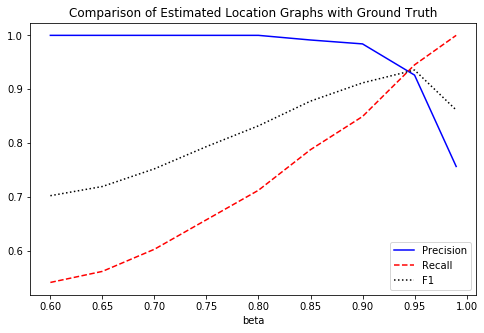

In [40]:
plt.figure(figsize=(8,5))
plt.plot(available_factors,Precision,'b')
plt.plot(available_factors,Recall,'r',linestyle='--')
plt.plot(available_factors,2*np.array(Recall)*np.array(Precision)/(np.array(Recall)+np.array(Precision)),'k',linestyle=':')
plt.legend(('Precision', 'Recall', 'F1'))
plt.title('Comparison of Estimated Location Graphs with Ground Truth')
plt.xlabel('beta')
plt.show()

### In-Depth Analysis of Individual Parameter Combinations

In [ ]:
# determine parameters of the pruning algorithm that should be investigated in detail
beta=0.8
knn=[]
alpha=[]

In [22]:
estimate=pd.read_csv(REGION+'/Distances_%.3f.csv' % beta)
estimate.rename({'name1':'Source','name2':'Target','distance':'Distance'},axis=1,inplace=True)
G_est=nx.from_pandas_edgelist(estimate,'Source','Target',['Distance'])
est_edges=[set(edge) for edge in list(G_est.edges)]
est_edges=set(frozenset(s) for s in est_edges)

print('Locations in Ground Truth: '+str(len(np.unique(np.append(ground_truth.Source.unique(),ground_truth.Target.unique())))))
print('Locations in Estimate: '+str(len(np.unique(np.append(estimate.Source.unique(),estimate.Target.unique())))))

print('Routes in Ground Truth: '+str(len(G_gt.edges)))
print('Routes in Estimate: '+str(len(G_est.edges)))
print('Number of common routes: ' + str(len(est_edges.intersection(gt_edges))))
print('Number of routes missing in ground truth: '+str(len(G_est.edges-G_gt.edges)))
print('Number of routes missing in estimate: '+str(len(G_gt.edges-G_est.edges)))

Locations in Ground Truth: 62
Locations in Estimate: 62
Routes in Ground Truth: 107
Routes in Estimate: 104
Number of common routes: 104
Number of routes missing in ground truth: 0
Number of routes missing in estimate: 3


Print routes in the ground truth that are missing in the estimate:

In [23]:
G_gt.edges-G_est.edges

{('Gamboula', 'Nola'), ('Gbadolite', 'Bangui'), ('Mboti', 'Mobaye')}

Print routes in the estimate that are missing in the ground truth:

In [24]:
G_est.edges-G_gt.edges

set()

# 4b. Plotting Location Graph<a class="anchor" id="4b"></a>

By default, the parameter `REGION_SPECS` is taken for visualization.

### Settings and Loading

In [11]:
TYPE=2 # currently, only rectangular regions are supported
TYPE_2=1 # currently, only plotting without background is supported

# determine parameters of the pruning algorithm selected for plotting
beta=0.95
knn=[]
alpha=[]
estimate=pd.read_csv(REGION+'/Distances_%.3f.csv' % beta)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
if os.path.isfile(REGION+'/Groundtruth.csv'):
    ground_truth=pd.read_csv(REGION+'/Groundtruth.csv')
    GT_flag=True
else:
    GT_flag=False

### Put the locations into a GeoPandas dataframe

In [6]:
# Get the name, longitude and latitude of the locations from the locations file
help_locations = Locations['name'].tolist()
help_lat = Locations['lat'].tolist()
help_lon = Locations['lon'].tolist()
    
# Define a dictionary containing the location names
data = {'Name': help_locations, 'lat': help_lat, 'lon': help_lon} 
  
# Convert the dictionary into a GeoDataFrame (includes latitude, longitude and name)
df_Region = gpd.GeoDataFrame(data) 

In [7]:
# Take the longitude ('lon') and latitude ('lat') of the locations, put them in a GeoSeries (e.g. POINT) and then in the GeoDataFrame
help = []

for i in range(df.shape[0]):
    help.append(Point(df['lon'].iloc[i], df['lat'].iloc[i]))

df_Region['geometry'] = help

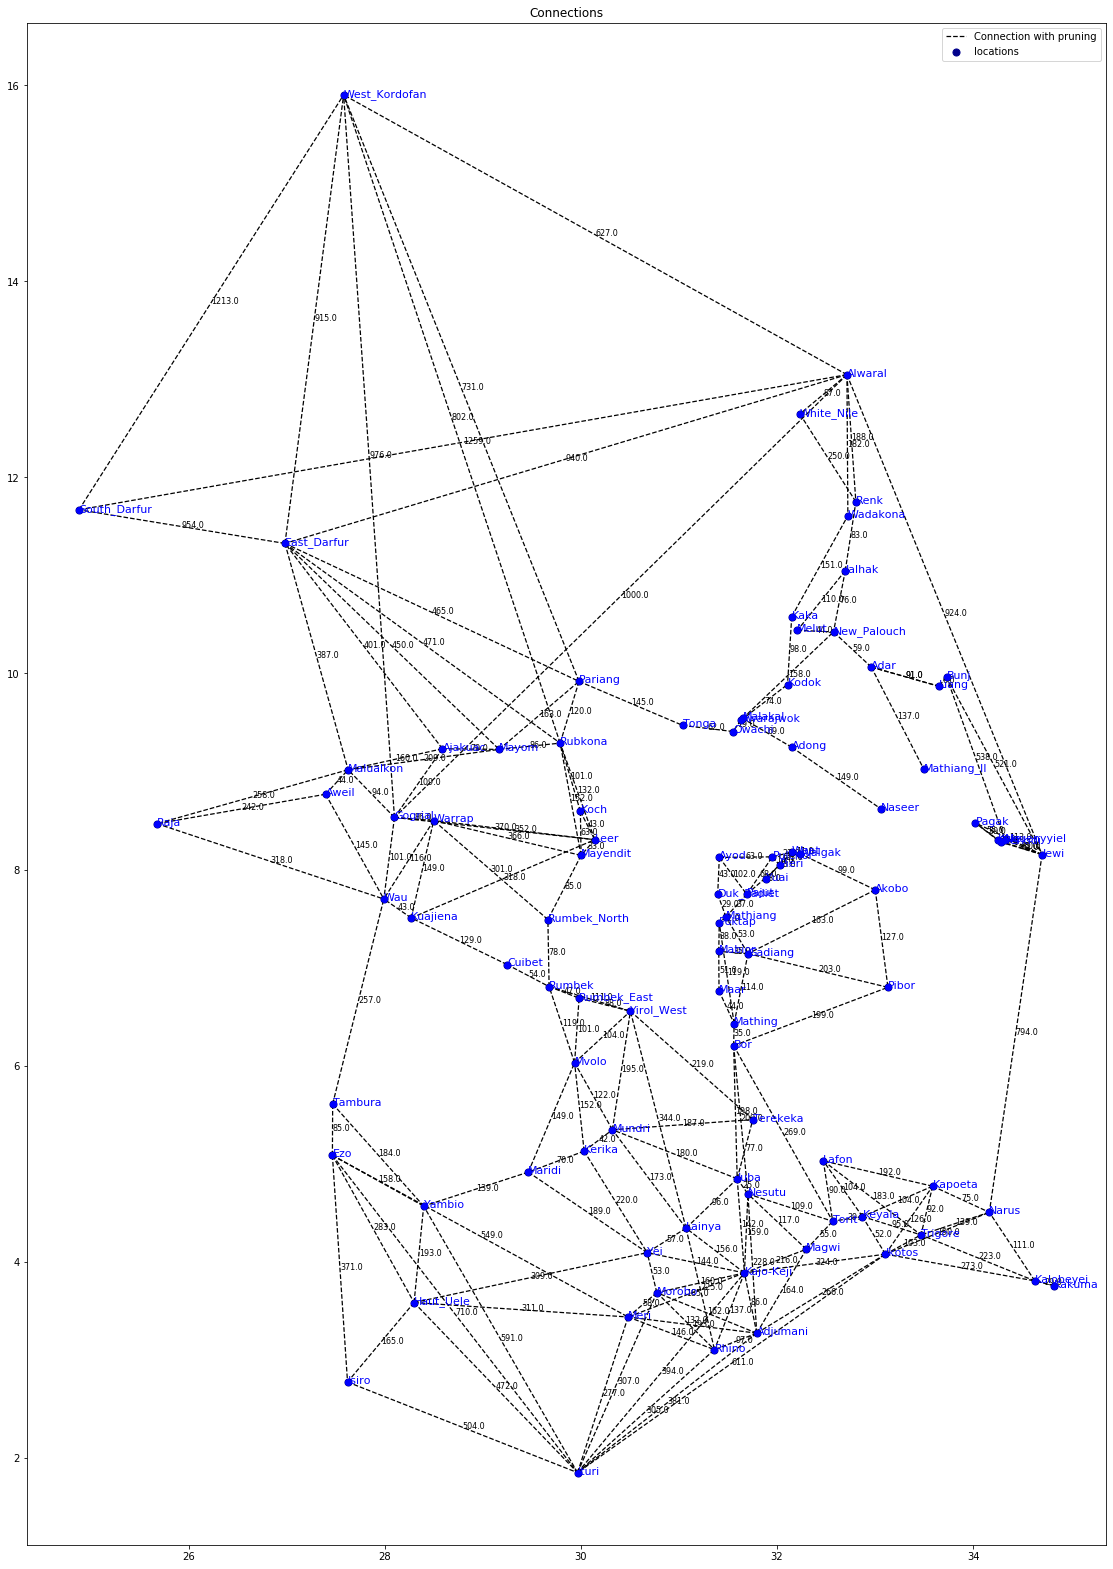

In [13]:
# Plot for the specified region

# Plot
fig,ax = plt.subplots(figsize = (28,28))

# Country code and no background
if (TYPE == '1' and TYPE_2 == '1'):
    world[(world['name'].isin(help))].plot(ax=ax, color='white', edgecolor='black',figsize = (15,15))
    
# Country code and road network as background
if (TYPE == '1' and TYPE_2 == '2'):
    world[(world['name'].isin(help))].plot(ax=ax, color='white', edgecolor='black',figsize = (15,15))
    map3.plot(ax=ax, color='limegreen', linewidth=0.5, alpha=0.9)
    
# Coordinates and no background    
if (TYPE == '2' and TYPE_2 == '1'):
    world[(world['name'].isin(help))].plot(ax=ax, color='white', edgecolor='black',figsize = (15,15))

# Coordinates and road network as background
if (TYPE == '2' and TYPE_2 == '2'):
    map3.plot(ax=ax, color='limegreen', linewidth=0.5, alpha=0.9)  


df_Region.plot(ax=ax, markersize=50, color='darkblue', marker='o', label='locations')

x = Locations['lon'].tolist()
y = Locations['lat'].tolist()

if GT_flag:
    # Groundtruth connections
    def connectpoints(x,y,p1,p2):
        x1, x2 = x[p1], x[p2]
        y1, y2 = y[p1], y[p2]
        plt.plot([x1,x2], [y1,y2], linestyle='solid', color='orange', linewidth=6, alpha=0.5)

    # Groundtruth connections with label
    def connectpoints_2(x,y,p1,p2):
        x1, x2 = x[p1], x[p2]
        y1, y2 = y[p1], y[p2]
        plt.plot([x1,x2], [y1,y2], linestyle='solid', color='orange', linewidth=6, alpha=0.5, label='true connection')
        #plt.annotate(dist, xy=((x1+x2)/2, (y1+y2)/2), size=11)

# Pruned connections
def connectpoints2(x,y,p1,p2,dist):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2], [y1,y2], linestyle='--', color='black', linewidth=1.25)
    plt.annotate(dist, xy=((x1+x2)/2, (y1+y2)/2-0.01), size=8)
    
# Pruned connections with label
def connectpoints2_2(x,y,p1,p2,dist):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2], [y1,y2], linestyle='--', color='black', linewidth=1.25, label='Connection with pruning')
    plt.annotate(dist, xy=((x1+x2)/2, (y1+y2)/2-0.01), size=8)

if GT_flag:
    # True connections
    for i in range(1):
        connectpoints_2(x,y,Locations[Locations['name'] == ground_truth.iloc[i]['Source']].index[0],Locations[Locations['name'] == ground_truth.iloc[i]['Target']].index[0])

    for i in range(ground_truth.shape[0]):
        connectpoints(x,y,Locations[Locations['name'] == ground_truth.iloc[i]['Source']].index[0],Locations[Locations['name'] == ground_truth.iloc[i]['Target']].index[0])

# Pruned connections
for i in range(1):
    connectpoints2_2(x,y,Locations[Locations['name'] == estimate.iloc[i]['name1']].index[0],Locations[Locations['name'] == estimate.iloc[i]['name2']].index[0], estimate.iloc[i]['distance'].round())

for i in range(estimate.shape[0]):
    connectpoints2(x,y,Locations[Locations['name'] == estimate.iloc[i]['name1']].index[0],Locations[Locations['name'] == estimate.iloc[i]['name2']].index[0], estimate.iloc[i]['distance'].round())
    

# Names of the locations
for i, txt in enumerate(df_Region['Name']):
    ax.annotate(txt, (df_Region['lon'][i], df_Region['lat'][i]-0.015), color='blue', size=11)
  
plt.scatter(x, y, color='blue', marker='o', zorder=10)

plt.legend()
plt.title('Connections')
plt.savefig(REGION + '/Network_%.3f.pdf' % beta) 
plt.show()